## Análise de processos envolvendo contas suspensas no tiktok

In [1]:
import pandas as pd
import numpy as np


# novo pacote que vamos usar!
import juscraper as jus


### Baixando os processos

In [2]:
tjsp = jus.scraper('tjsp', verbose=1, download_path='tiktok', sleep_time=1)

Caminho de download definido como 'tiktok'.


In [4]:
dados = tjsp.cjpg(pesquisa = 'tiktok')

Total de páginas: 71
Pagina inicial: 1
Pagina final: 71


Processando documentos: 100%|██████████| 71/71 [00:03<00:00, 20.99it/s]


In [5]:
# dados.to_parquet('tiktok.parquet')

In [6]:
dados = pd.read_parquet('tiktok.parquet')

In [5]:
dados.head(3)

,cd_processo,id_processo,classe,assunto,magistrado,comarca,foro,vara,data_disponibilizacao,decisao
0,2S001Y5RY0000,1190250-27.2024.8.26.0100,Procedimento Comum Cível,Práticas Abusivas,FLAVIA POYARES MIRANDA,SÃO PAULO,Foro Central Cível,28ª Vara Cível,03/02/2025,SENTENÇA\n\n\n\nProcesso nº:\t1190250-27.2024....
1,2S001X25Z0000,1152882-81.2024.8.26.0100,Procedimento Comum Cível,Responsabilidade do Fornecedor,Juliana Pitelli da Guia,SÃO PAULO,Foro Central Cível,28ª Vara Cível,31/01/2025,SENTENÇA\n\n\n\nProcesso Digital nº:\t1152882-...
2,6C000577K0000,1000096-22.2025.8.26.0228,Procedimento Comum Cível,Responsabilidade do Fornecedor,FLAVIA POYARES MIRANDA,SÃO PAULO,Foro Central Cível,28ª Vara Cível,31/01/2025,SENTENÇA\n\n\n\nProcesso nº:\t1000096-22.2025....


In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cd_processo            692 non-null    object
 1   id_processo            692 non-null    object
 2   classe                 692 non-null    object
 3   assunto                692 non-null    object
 4   magistrado             692 non-null    object
 5   comarca                692 non-null    object
 6   foro                   692 non-null    object
 7   vara                   692 non-null    object
 8   data_disponibilizacao  692 non-null    object
 9   decisao                692 non-null    object
dtypes: object(10)
memory usage: 54.2+ KB


### Analisando os dados das decisões

In [7]:
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Literal
import os

load_dotenv()

client = OpenAI()

In [9]:
prompt = """
Você é um assistente de inteligência artificial que processa dados de 
sentenças judiciais. Seu objetivo é extrair informações relevantes sobre
o caso, para auxiliar em análises estatísticas posteriores.

Você receberá o texto de uma sentença e deverá produzir, com base nela,
produzirá um JSON com a estrutura especificada.

O escopo dos dados que estamos analisando são casos de pessoas que alegam
ter suas contas bloqueadas no tiktok e buscam alguma indenização.
"""

In [10]:
class esquema_resposta(BaseModel):
    escopo: bool = Field(..., description="A sentença faz parte do escopo?")
    nome_autor: str = Field(..., description = "Nome do autor do processo")
    conta_popular: bool = Field(..., description="A conta do tiktok possui mais de 1 milhão de inscritos?")
    danos_morais: float = Field(..., description="Qual o valor dos danos morais?")
    danos_materiais: float = Field(..., description="Qual o valor dos danos materiais?")
    procedencia: Literal['procedente','parcialmente procedente','improcedente']
    danos_morais_decisao: float = Field(..., description="Qual o valor dos danos morais na decisão?")
    danos_materiais_decisao: float = Field(..., description="Qual o valor dos danos materiais na decisão?")

In [11]:
def analisar_sentenca(sentenca):
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": prompt + sentenca}
        ],
        temperature=0.0,
        response_format=esquema_resposta
    )
    return pd.DataFrame([response.choices[0].message.parsed.model_dump()])

In [12]:
print(dados['decisao'][0])

SENTENÇA



Processo nº:	1190250-27.2024.8.26.0100

Classe - Assunto	Procedimento Comum Cível - Práticas Abusivas

Requerente:	Paulo Henrique dos Santos

Requerido:	Bytedance Brasil Tecnologia Ltda.







Juiz(a) de Direito: Dr(a). FLAVIA POYARES MIRANDA





Vistos.



PAULO HENRIQUE DOS SANTOS, parte qualificada nos autos, ingressou com ação de obrigação de fazer e indenização por danos morais com pedido de liminar de tutela de urgência em face de Bytedance Brasil Tecnologia Ltda., também qualificado. Alega a parte autora que é proprietária de perfil mantido no TikTok , intitulado @motosdesenhos. Contudo, em 26 de novembro de 2024, perdeu o acesso à sua rede social, que foi suspensa pela requerida sem quaisquer esclarecimentos. Apesar dos esforços para resolver a questão administrativamente, requerida não reativou o perfil. Requer, portanto, a concessão do pedido de tutela antecipada e, ao final, a condenação da requerida no restabelecimento do perfil @motosdesenhos na plataforma Ti

In [13]:
analisar_sentenca(dados['decisao'][0])

,escopo,nome_autor,conta_popular,danos_morais,danos_materiais,procedencia,danos_morais_decisao,danos_materiais_decisao
0,True,Paulo Henrique dos Santos,False,5000.0,0.0,procedente,5000.0,0.0


In [115]:
# analises = []
# for sentenca in dados['decisao']:
#     analises.append(analisar_sentenca(sentenca))
  
# df_analises = pd.concat(analises).reset_index(drop=True)

In [116]:
## ana maria braga
#df_analises.to_csv('analises.csv', index=False)

In [14]:
df_analises = pd.read_csv('analises.csv')

In [15]:
amostra_concat = pd.concat([dados, df_analises], axis=1)

In [16]:
amostra_concat

,cd_processo,id_processo,classe,assunto,magistrado,comarca,foro,vara,data_disponibilizacao,decisao,escopo,nome_autor,conta_popular,danos_morais,danos_materiais,procedencia,danos_morais_decisao,danos_materiais_decisao
0,2S001Y5RY0000,1190250-27.2024.8.26.0100,Procedimento Comum Cível,Práticas Abusivas,FLAVIA POYARES MIRANDA,SÃO PAULO,Foro Central Cível,28ª Vara Cível,03/02/2025,SENTENÇA\n\n\n\nProcesso nº:\t1190250-27.2024....,True,Maximiliano Freide Duarte,False,10000.0,0.0,improcedente,0.0,0.0
1,2S001X25Z0000,1152882-81.2024.8.26.0100,Procedimento Comum Cível,Responsabilidade do Fornecedor,Juliana Pitelli da Guia,SÃO PAULO,Foro Central Cível,28ª Vara Cível,31/01/2025,SENTENÇA\n\n\n\nProcesso Digital nº:\t1152882-...,True,Josely Ferreira Ribeiro,False,5000.0,0.0,parcialmente procedente,5000.0,0.0
2,6C000577K0000,1000096-22.2025.8.26.0228,Procedimento Comum Cível,Responsabilidade do Fornecedor,FLAVIA POYARES MIRANDA,SÃO PAULO,Foro Central Cível,28ª Vara Cível,31/01/2025,SENTENÇA\n\n\n\nProcesso nº:\t1000096-22.2025....,True,Raiany da Silva Coelho,False,10000.0,0.0,parcialmente procedente,8000.0,0.0
3,8Y0004AXS0000,1004833-14.2024.8.26.0322,Procedimento Comum Cível,Indenização por Dano Moral,Alexandre Felix da Silva,Lins,Foro de Lins,1ª Vara Cível,30/01/2025,SENTENÇA\n\n\n\nProcesso nº:\t1004833-14.2024....,False,Ivonete Luiza Lima da Rocha,False,0.0,0.0,improcedente,0.0,0.0
4,04001B1LF0000,1018667-68.2024.8.26.0004,Procedimento do Juizado Especial Cível,Indenização por Dano Moral,MARIANA HORTA GREENHALGH,SÃO PAULO,Foro Regional IV - Lapa,1ª Vara do Juizado Especial Cível,30/01/2025,SENTENÇA\n\n\n\nProcesso Digital nº:\t1018667-...,True,RODRIGO LUCIANO DE SOUZA,False,0.0,5000.0,parcialmente procedente,0.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Gabriela Bittencourt Pereira,False,0.0,0.0,parcialmente procedente,0.0,0.0
697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Paulo Regis Andrade,False,0.0,0.0,improcedente,0.0,0.0
698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Larissa Pereira Cavalcante,False,0.0,0.0,improcedente,0.0,0.0
699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Adriana Barreto Benite,True,20.0,20.0,improcedente,0.0,0.0


### Análises descritivas

In [17]:
amostra_concat.value_counts('escopo')

escopo
True     501
False    200
Name: count, dtype: int64

In [18]:
df = amostra_concat.query('escopo')
df = df.copy()

In [19]:
df.value_counts('conta_popular')

conta_popular
False    450
True      51
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='procedencia'>

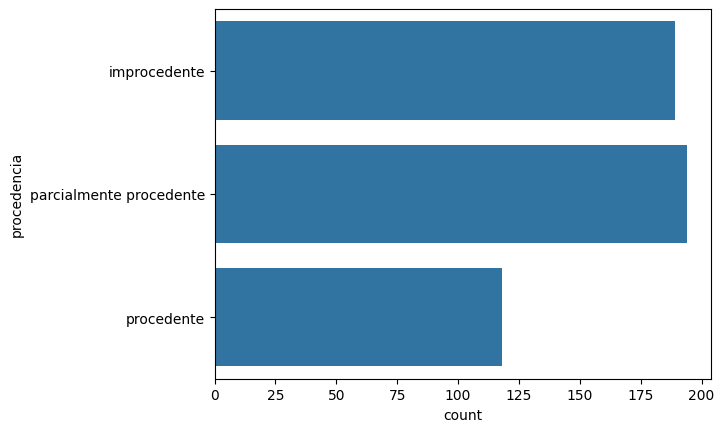

In [20]:
import seaborn as sns

sns.countplot(df, y='procedencia')

<Axes: xlabel='ano_mes', ylabel='contagem'>

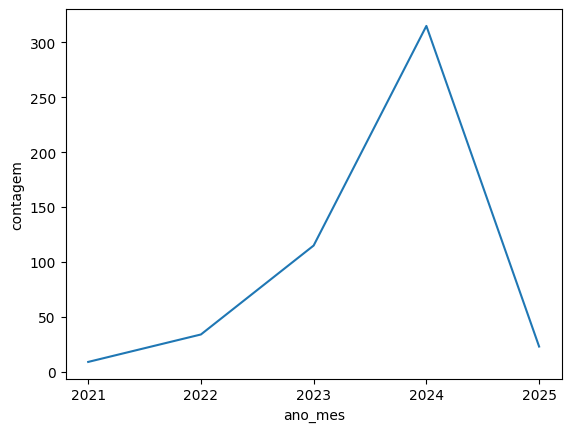

In [21]:
df['data_disponibilizacao'] = pd.to_datetime(df['data_disponibilizacao'], format='%d/%m/%Y')
df['ano_mes'] = df['data_disponibilizacao'].dt.to_period('Y')

df_agg = df.value_counts('ano_mes', sort=False).reset_index(name='contagem')
df_agg['ano_mes'] = df_agg['ano_mes'].astype(str)

sns.lineplot(data=df_agg, x='ano_mes', y='contagem')

<Axes: xlabel='danos_morais', ylabel='Count'>

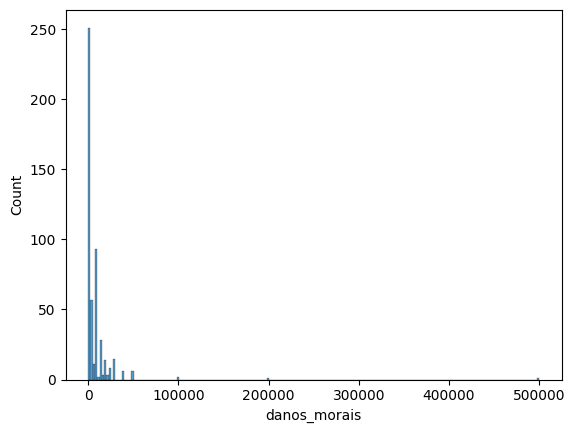

In [21]:
sns.histplot(df, x='danos_morais')

<Axes: xlabel='danos_morais', ylabel='danos_morais_decisao'>

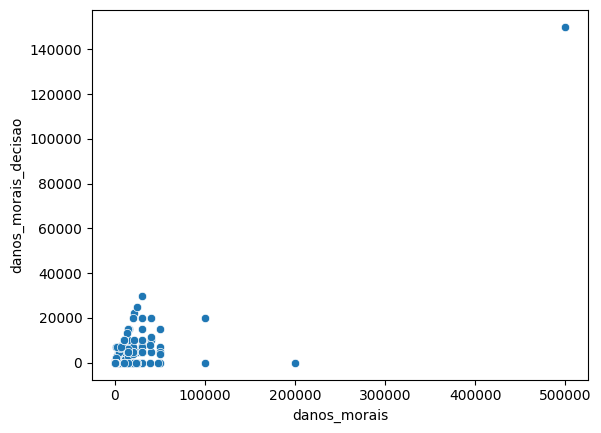

In [22]:
sns.scatterplot(data=df, x='danos_morais', y = 'danos_morais_decisao')

<Axes: xlabel='danos_materiais', ylabel='danos_materiais_decisao'>

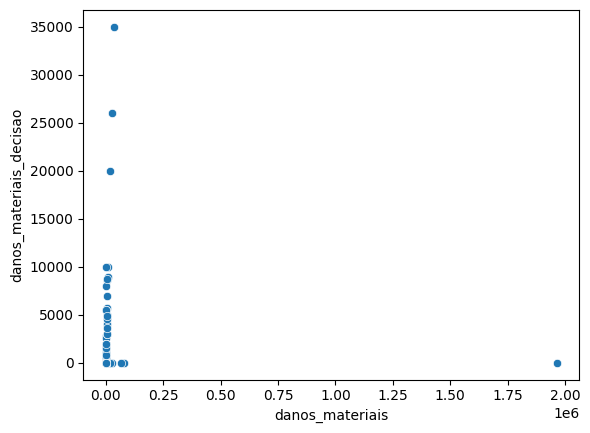

In [23]:
sns.scatterplot(data=df, x='danos_materiais', y = 'danos_materiais_decisao')

<Axes: xlabel='danos_morais_decisao', ylabel='classe'>

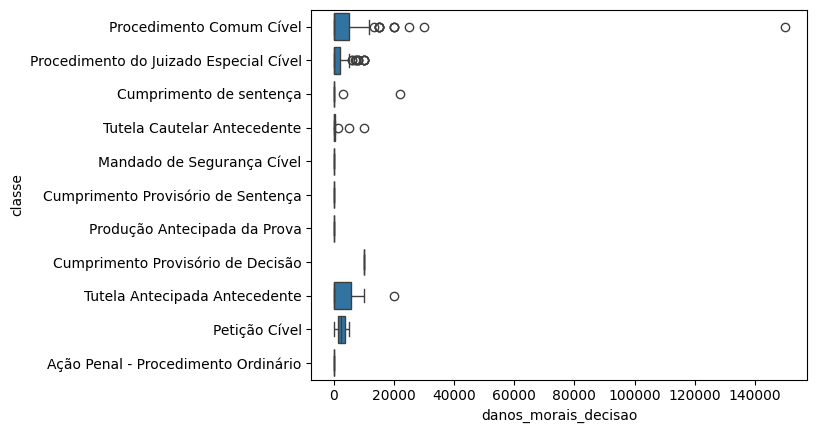

In [24]:
sns.boxplot(data=df, y='classe', x = 'danos_morais_decisao')

In [25]:
df.head()

,cd_processo,id_processo,classe,assunto,magistrado,comarca,foro,vara,data_disponibilizacao,decisao,escopo,nome_autor,conta_popular,danos_morais,danos_materiais,procedencia,danos_morais_decisao,danos_materiais_decisao,ano_mes
0,2S001X25Z0000,1152882-81.2024.8.26.0100,Procedimento Comum Cível,Responsabilidade do Fornecedor,Juliana Pitelli da Guia,SÃO PAULO,Foro Central Cível,28ª Vara Cível,2025-01-31,SENTENÇA\n\n\n\nProcesso Digital nº:\t1152882-...,True,Maximiliano Freide Duarte,False,10000.0,0.0,improcedente,0.0,0.0,2025
1,6C000577K0000,1000096-22.2025.8.26.0228,Procedimento Comum Cível,Responsabilidade do Fornecedor,FLAVIA POYARES MIRANDA,SÃO PAULO,Foro Central Cível,28ª Vara Cível,2025-01-31,SENTENÇA\n\n\n\nProcesso nº:\t1000096-22.2025....,True,Josely Ferreira Ribeiro,False,5000.0,0.0,parcialmente procedente,5000.0,0.0,2025
2,8Y0004AXS0000,1004833-14.2024.8.26.0322,Procedimento Comum Cível,Indenização por Dano Moral,Alexandre Felix da Silva,Lins,Foro de Lins,1ª Vara Cível,2025-01-30,SENTENÇA\n\n\n\nProcesso nº:\t1004833-14.2024....,True,Raiany da Silva Coelho,False,10000.0,0.0,parcialmente procedente,8000.0,0.0,2025
4,0G000AE910000,1021310-94.2023.8.26.0016,Procedimento do Juizado Especial Cível,Obrigações,Juliana Maria Maccari Gonçalves,SÃO PAULO,Foro Central Juizados Especiais Cíveis,2ª Vara do Juizado Especial Cível - Vergueiro,2025-01-30,SENTENÇA\n\n\n\nProcesso nº:\t1021310-94.2023....,True,RODRIGO LUCIANO DE SOUZA,False,0.0,5000.0,parcialmente procedente,0.0,5000.0,2025
5,2S001WWG40000,1147415-24.2024.8.26.0100,Procedimento Comum Cível,Práticas Abusivas,Sergio Serrano Nunes Filho,SÃO PAULO,Foro Central Cível,11ª Vara Cível,2025-01-29,C O N C L U S Ã O\n\n\n\nEm 29 de janeiro de 2...,True,Endriw Araújo,False,10000.0,0.0,parcialmente procedente,0.0,0.0,2025


### Modelo

In [22]:
df['indenizacao'] = df['danos_morais_decisao'] + df['danos_materiais_decisao']

In [23]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.ols(
  formula='indenizacao ~ danos_morais + danos_materiais + conta_popular', 
  data=df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            indenizacao   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     241.3
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           1.37e-96
Time:                        16:26:35   Log-Likelihood:                -5002.3
No. Observations:                 501   AIC:                         1.001e+04
Df Residuals:                     497   BIC:                         1.003e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               907.1396    259.671      3.493      0.001     396.950    1417.329
conta_popular[T.True]  1221.3814    778.771      1.568      0.117    -308.708    2751.471
danos_morais              0.2396      0.009     26.610      0.000       0.222       0.257
danos_materiais           0.0080      0.003      2.994      0.003       0.003       0.013
==============================================================================
Omnibus:                      172.678   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15673.250
Skew:                           0.433   Prob(JB):                         0.00
Kurtosis:                      30.387   Cond. No.                     2.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

E a probabilidade de ganhar?

In [29]:
df

,cd_processo,id_processo,classe,assunto,magistrado,comarca,foro,vara,data_disponibilizacao,decisao,...,nome_autor,conta_popular,danos_morais,danos_materiais,procedencia,danos_morais_decisao,danos_materiais_decisao,ano_mes,indenizacao,procedente
0,2S001X25Z0000,1152882-81.2024.8.26.0100,Procedimento Comum Cível,Responsabilidade do Fornecedor,Juliana Pitelli da Guia,SÃO PAULO,Foro Central Cível,28ª Vara Cível,2025-01-31,SENTENÇA\n\n\n\nProcesso Digital nº:\t1152882-...,...,Maximiliano Freide Duarte,False,10000.0,0.0,improcedente,0.0,0.0,2025,0.0,0
1,6C000577K0000,1000096-22.2025.8.26.0228,Procedimento Comum Cível,Responsabilidade do Fornecedor,FLAVIA POYARES MIRANDA,SÃO PAULO,Foro Central Cível,28ª Vara Cível,2025-01-31,SENTENÇA\n\n\n\nProcesso nº:\t1000096-22.2025....,...,Josely Ferreira Ribeiro,False,5000.0,0.0,parcialmente procedente,5000.0,0.0,2025,5000.0,1
2,8Y0004AXS0000,1004833-14.2024.8.26.0322,Procedimento Comum Cível,Indenização por Dano Moral,Alexandre Felix da Silva,Lins,Foro de Lins,1ª Vara Cível,2025-01-30,SENTENÇA\n\n\n\nProcesso nº:\t1004833-14.2024....,...,Raiany da Silva Coelho,False,10000.0,0.0,parcialmente procedente,8000.0,0.0,2025,8000.0,1
4,0G000AE910000,1021310-94.2023.8.26.0016,Procedimento do Juizado Especial Cível,Obrigações,Juliana Maria Maccari Gonçalves,SÃO PAULO,Foro Central Juizados Especiais Cíveis,2ª Vara do Juizado Especial Cível - Vergueiro,2025-01-30,SENTENÇA\n\n\n\nProcesso nº:\t1021310-94.2023....,...,RODRIGO LUCIANO DE SOUZA,False,0.0,5000.0,parcialmente procedente,0.0,5000.0,2025,5000.0,1
5,2S001WWG40000,1147415-24.2024.8.26.0100,Procedimento Comum Cível,Práticas Abusivas,Sergio Serrano Nunes Filho,SÃO PAULO,Foro Central Cível,11ª Vara Cível,2025-01-29,C O N C L U S Ã O\n\n\n\nEm 29 de janeiro de 2...,...,Endriw Araújo,False,10000.0,0.0,parcialmente procedente,0.0,0.0,2025,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,2S001FQXD0000,1071058-08.2021.8.26.0100,Procedimento Comum Cível,Prestação de Serviços,Guilherme Ferreira da Cruz,SÃO PAULO,Foro Central Cível,45ª Vara Cível,2021-10-12,"CONCLUSÃO\n\nEm 12 de outubro de 2021, faço co...",...,Fernanda Mota Farhat,False,0.0,2000.0,procedente,0.0,2000.0,2021,2000.0,1
695,B9000EUYK0000,1006440-12.2021.8.26.0405,Procedimento Comum Cível,Direito de Imagem,MARIANA HORTA GREENHALGH,Osasco,Foro de Osasco,7ª Vara Cível,2021-09-17,SENTENÇA\n\n\n\nProcesso nº:\t1006440-12.2021....,...,Beatriz Montanheiro Silva,False,30000.0,0.0,parcialmente procedente,5000.0,0.0,2021,5000.0,1
696,2S001FVDE0000,1074100-65.2021.8.26.0100,Procedimento Comum Cível,Obrigação de Fazer / Não Fazer,Andrea de Abreu,SÃO PAULO,Foro Central Cível,10ª Vara Cível,2021-08-12,"CONCLUSÃO\n\nEm , faço estes autos conclusos a...",...,Gabriela Bittencourt Pereira,False,0.0,0.0,parcialmente procedente,0.0,0.0,2021,0.0,1
698,36000OXNO0000,1031888-21.2020.8.26.0114,Procedimento do Juizado Especial Cível,Direito de Imagem,Henrique Nader,Campinas,Foro de Campinas,2ª Vara do Juizado Especial Cível,2021-06-21,SENTENÇA\n\n\n\nProcesso Digital nº:\t1031888-...,...,Larissa Pereira Cavalcante,False,0.0,0.0,improcedente,0.0,0.0,2021,0.0,0


In [24]:
df['procedente'] = np.where(df['procedencia'].isin(['procedente', 'parcialmente procedente']), 1, 0)
df['prop_magistrado'] = df.groupby('magistrado')['procedente'].transform('mean')

In [26]:
model_logistico = smf.logit(
  formula='procedente ~ danos_morais + danos_materiais + conta_popular + prop_magistrado', 
  data=df
).fit() 

model_logistico.summary()

Optimization terminated successfully.
         Current function value: 0.287325
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             procedente   No. Observations:                  496
Model:                          Logit   Df Residuals:                      491
Method:                           MLE   Df Model:                            4
Date:                Mon, 03 Feb 2025   Pseudo R-squ.:                  0.5664
Time:                        16:28:11   Log-Likelihood:                -142.51
converged:                       True   LL-Null:                       -328.64
Covariance Type:            nonrobust   LLR p-value:                 2.738e-79
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.4890      0.503     -8.933      0.000      -5.474      -3.504
conta_popular[T.True]     0.4593      0.512      0.896      0.370      -0.545       1.463
danos_morais            9.17e-06   9.53e-06      0.962      0.336   -9.51e-06    2.78e-05
danos_materiais        3.867e-05   3.52e-05      1.098      0.272   -3.04e-05       0.000
prop_magistrado           8.2584      0.809     10.212      0.000       6.673       9.844
=========================================================================================
"""

## Conclusão:

Você é uma advogada/advogado em início de carreira, buscando atuar na área de direito digital.

Pesquisando sobre o tema, você considerou investir na área de atuação de indenização por contas bloqueadas no tiktok.

Antes, no entanto, você fez uma análise preliminar no TJSP para obter alguns dados de casos anteriores do tema.

Com base em 501 processos, você elaborou dois estudos de regressão:

OLS Regression Results
Dep. Variable:	indenizacao	R-squared:	0.593
Model:	OLS	Adj. R-squared:	0.590
Method:	Least Squares	F-statistic:	241.3
Date:	Sun, 02 Feb 2025	Prob (F-statistic):	1.37e-96
Time:	20:02:58	Log-Likelihood:	-5002.3
No. Observations:	501	AIC:	1.001e+04
Df Residuals:	497	BIC:	1.003e+04
Df Model:	3		
Covariance Type:	nonrobust		
coef	std err	t	P>|t|	[0.025	0.975]
Intercept	907.1396	259.671	3.493	0.001	396.950	1417.329
conta_popular[T.True]	1221.3814	778.771	1.568	0.117	-308.708	2751.471
danos_morais	0.2396	0.009	26.610	0.000	0.222	0.257
danos_materiais	0.0080	0.003	2.994	0.003	0.003	0.013
Omnibus:	172.678	Durbin-Watson:	1.928
Prob(Omnibus):	0.000	Jarque-Bera (JB):	15673.250
Skew:	0.433	Prob(JB):	0.00
Kurtosis:	30.387	Cond. No.	2.93e+05



Logit Regression Results
Dep. Variable:	procedente	No. Observations:	501
Model:	Logit	Df Residuals:	497
Method:	MLE	Df Model:	3
Date:	Sun, 02 Feb 2025	Pseudo R-squ.:	0.01939
Time:	20:03:11	Log-Likelihood:	-325.58
converged:	True	LL-Null:	-332.01
Covariance Type:	nonrobust	LLR p-value:	0.004920
coef	std err	z	P>|z|	[0.025	0.975]
Intercept	0.2807	0.114	2.454	0.014	0.057	0.505
conta_popular[T.True]	0.6052	0.337	1.793	0.073	-0.056	1.267
danos_morais	2.208e-05	9.82e-06	2.248	0.025	2.83e-06	4.13e-05
danos_materiais	1.18e-05	1.93e-05	0.610	0.542	-2.61e-05	4.97e-05


Com base nessas análises, decida se vale a pena investir tempo, estudo e marketing digital para abrir essa área de atuação
